#### Change detection: point-to-point z-difference

In [138]:
import laspy 
import numpy as np
import os
from sklearn.neighbors import KDTree

folder_path_5p = r"E:\ALS_DATA\NLS_5p_PADASJOKI_road_patches\laz_files_split_along_road_vectors_with_dl_predictions"
folder_path_20p = r"E:\ALS_DATA\NLS_20p_EVO_road_patches_with_preds"
buffer_of_median_z_diff = []
buffer_of_mean_z_diff = []
buffer_of_z_diff = []
middle_points = []
middle_points_large_dist = []

no_overlap_counter = 0
counter = 0

for file in os.listdir(folder_path_20p):
    data_5p_laz = os.path.splitext(file)[0] + ".laz"

    data_5p = os.path.join(folder_path_5p, data_5p_laz)
    data_20p = os.path.join(folder_path_20p, file)

    points_5p = laspy.read(data_5p)
    points_20p = laspy.read(data_20p)

    xyz_5p = np.vstack((points_5p.x, points_5p.y, points_5p.z)).T
    xyz_20p = np.vstack((points_20p.x, points_20p.y, points_20p.z)).T

    predictions_5p = points_5p.prediction

    mask = predictions_5p != 1
    xyz_5p_filtered = xyz_5p[mask]

    splitcode_5p = points_5p[mask].splitcode

    predictions_20p = points_20p.prediction
    mask20 = predictions_20p != 1
    xyz_20p_road = xyz_20p[mask20]


    if mask.sum() > 50:
        tree = KDTree(xyz_20p_road)
        dist, idx = tree.query(xyz_5p_filtered, k=1)

        for i in np.unique(splitcode_5p):
            # z_diff = xyz_20p[idx.flatten(), 2] - xyz_5p_filtered[:, 2]

            splitcode_mask = splitcode_5p == i
            xyz_5p_splitcode_filtered = xyz_5p_filtered[splitcode_mask]

            xyz_20p_filtered = xyz_20p_road[idx.flatten()]
            z_diff = xyz_20p_filtered[splitcode_mask, 2] - xyz_5p_splitcode_filtered[:, 2]

            splitcode_dist = [dist for dist, m in zip(dist, splitcode_mask) if m]

            # if np.median(z_diff) < -1.5 or np.median(z_diff) > 1.5:
            #     print(np.median(z_diff))
            #     print(np.median(splitcode_dist))
            #     # print(len(z_diff[0]))
            #     print(file)
            #     print(i)

            if np.median(splitcode_dist) > 1.0:
                no_overlap_counter+=1
                center_xy = xyz_5p_splitcode_filtered[:, :2].mean(axis=0)
                middle_points_large_dist.append(center_xy)

            else:
                center_xy = xyz_5p_splitcode_filtered[:, :2].mean(axis=0)
                middle_points.append(center_xy)
                buffer_of_z_diff.append(z_diff)
                buffer_of_median_z_diff.append(np.median(z_diff))
                buffer_of_mean_z_diff.append(np.mean(z_diff))
                counter += 1

                # if np.median(z_diff) < -0.07 or np.median(z_diff) > 1.5:
                #     print(np.median(z_diff))
                #     # print(np.median(splitcode_dist))
                #     # print(len(z_diff[0]))
                #     print(file)
                #     print(i)
                
print(no_overlap_counter)
print(counter)
print(no_overlap_counter/counter)

3131
75602
0.041414248300309514


[-0.04  -0.06  -0.07  ... -0.02  -0.02  -0.025]


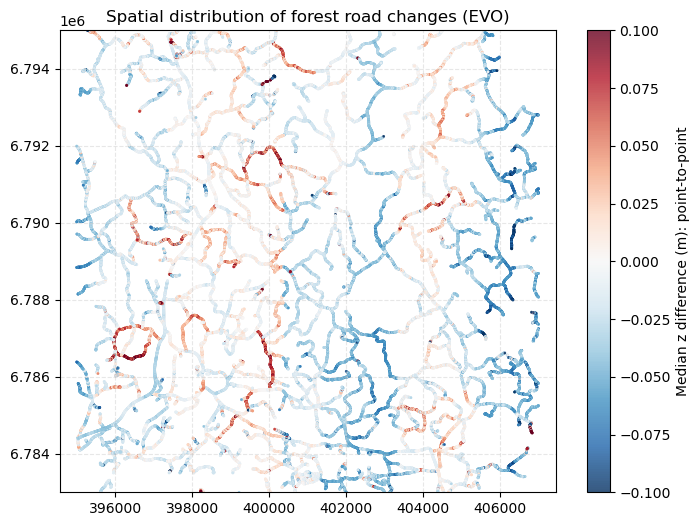

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

buffer_of_median_z_diff = np.array(buffer_of_median_z_diff)
print(buffer_of_median_z_diff)

middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    middle_points_x,               # X coordinates
    middle_points_y,               # Y coordinates
    c=buffer_of_median_z_diff,     # Color by z diff
    cmap='RdBu_r',                 # Blue for positive, red for negative
    s=1,                           
    alpha=0.8,
    vmin=-0.10, vmax=0.10         # Negative = red, Positive = blue
)

plt.colorbar(sc, label="Median z difference (m)")
plt.title("Forest road changes: point-to-point")
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')  # Keep aspect ratio true to scale

# plt.xlim([396000, 399500])
# plt.ylim([6783700,6788500])

plt.xlim(395000.0, 407000.0)
plt.ylim(6783000.0, 6795000.0)

plt.show()

#### Change detection: point-to-plane z-difference


In [150]:
import laspy 
import numpy as np
import os
from sklearn.neighbors import KDTree
import open3d as o3d

# time: 9min

import numpy as np

np.seterr(all='ignore')

folder_path_5p = r"E:\ALS_DATA\NLS_5p_PADASJOKI_road_patches\laz_files_split_along_road_vectors_with_dl_predictions"
folder_path_20p = r"E:\ALS_DATA\NLS_20p_EVO_road_patches_with_preds"

def fit_plane_svd(points):
    # centroid of the points
    centroid = np.mean(points, axis=0)
    _, _, vh = np.linalg.svd(points - centroid)
    # plane normal vector (A, B, C)
    normal = vh[-1]  
    A, B, C = normal

    # compute D such that Ax + By + Cz + D = 0
    D = -np.dot(normal, centroid)

    return A, B, C, D


def point_to_plane_distance(point, plane):
    A, B, C, D = plane
    x0, y0, z0 = point
    return (A*x0 + B*y0 + C*z0 + D) / np.sqrt(A*A + B*B + C*C)

def point_to_centroid_z_dist(point, neighbors):
    centroid = np.mean(neighbors, axis=0)
    return point[2] - centroid[2]


def point_to_plane_z_dist(point, plane):
    A, B, C, D = plane
    x0, y0, z0 = point
    
    # plane must not be vertical in z
    if abs(C) < 1e-9:
        # print(C)
        return -100000
        
    z_plane = -(A*x0 + B*y0 + D) / C
    return z_plane - z0    # signed z-distance

buffer_of_median_z_diff = []
buffer_of_mean_z_diff = []
buffer_of_z_diff = []
middle_points = []

for j, file in enumerate(os.listdir(folder_path_20p)):
    if j % 100 == 0:
        print(j)
    data_5p_laz = os.path.splitext(file)[0] + ".laz"

    data_5p = os.path.join(folder_path_5p, data_5p_laz)
    data_20p = os.path.join(folder_path_20p, file)

    points_5p = laspy.read(data_5p)
    points_20p = laspy.read(data_20p)

    xyz_5p = np.vstack((points_5p.x, points_5p.y, points_5p.z)).T
    xyz_20p = np.vstack((points_20p.x, points_20p.y, points_20p.z)).T

    predictions_5p = points_5p.prediction
    mask5 = predictions_5p != 1
    xyz_5p_road = xyz_5p[mask5]
    splitcode_5p = points_5p[mask5].splitcode

    predictions_20p = points_20p.prediction
    mask20 = predictions_20p != 1
    xyz_20p_road = xyz_20p[mask20]

    if mask5.sum() > 50:
        tree = KDTree(xyz_20p_road[:,:2])
        idx_list = tree.query_radius(xyz_5p_road[:,:2], r=0.7)

        planes = [None] * len(xyz_5p_road)
        # centroids = [None] * len(xyz_5p_road)

        for i, idxs in enumerate(idx_list):
            if len(idxs) >= 3:
                planes[i] = fit_plane_svd(xyz_20p_road[idxs, :3])
                # centroids[i] = np.mean(xyz_20p_road[idxs, :3], axis=0)

        # Compute aligned distances
        point_to_plane_distances = np.full(len(xyz_5p_road), np.nan)
        point_to_centoid_distances = np.full(len(xyz_5p_road), np.nan)

        for i, plane in enumerate(planes):
            if plane is not None:
                # point_to_plane_distances[i] = point_to_plane_distance(xyz_5p_road[i, :3], plane)
                point_to_plane_distances[i] = point_to_plane_z_dist(xyz_5p_road[i, :3], plane)
                # point_to_centoid_distances[i] = xyz_5p_road[i, 2] - centroid[2]
                # print(point_to_centoid_distances[i])
                

        for i in np.unique(splitcode_5p):
            splitcode_mask = splitcode_5p == i
            xyz_5p_splitcode_filtered = xyz_5p_road[splitcode_mask]

            point_to_plane_distances_splitcode = point_to_plane_distances[splitcode_mask]

            buffer_of_z_diff.append(point_to_plane_distances_splitcode)
            buffer_of_median_z_diff.append(np.median(point_to_plane_distances_splitcode))
            buffer_of_mean_z_diff.append(np.mean(point_to_plane_distances_splitcode))

            center_xy = xyz_5p_splitcode_filtered[:, :2].mean(axis=0)
            middle_points.append(center_xy)



0
100
200
300
400
500
600
700
800
900
1000
1100


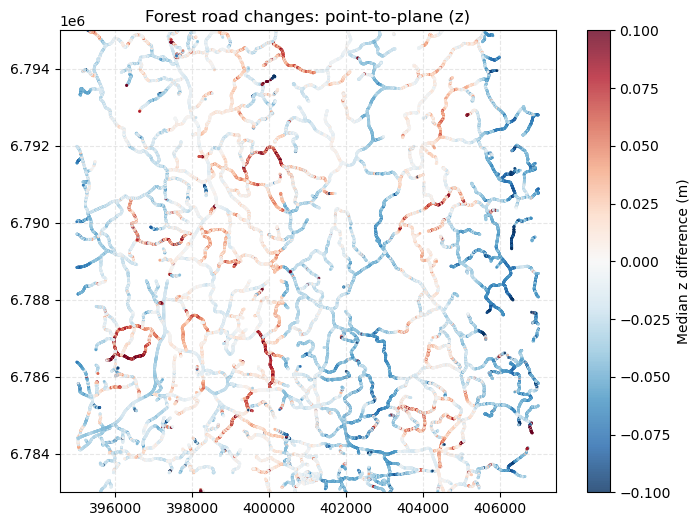

In [151]:
import numpy as np
import matplotlib.pyplot as plt


middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    middle_points_x,               # X coordinates
    middle_points_y,               # Y coordinates
    c=buffer_of_median_z_diff,     # Color by z diff
    cmap='RdBu_r',                 # Blue for positive, red for negative
    s=1,                           
    alpha=0.8,
    vmin=-0.1, vmax=0.1         # Negative = red, Positive = blue
)

plt.colorbar(sc, label="Median z difference (m)")
plt.title("Forest road changes: point-to-plane (z)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')  # Keep aspect ratio true to scale

# plt.xlim([396000, 399500])
# plt.ylim([6783700,6788500])

plt.xlim(395000.0, 407000.0)
plt.ylim(6783000.0, 6795000.0)

plt.show()

c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(
c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(
c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


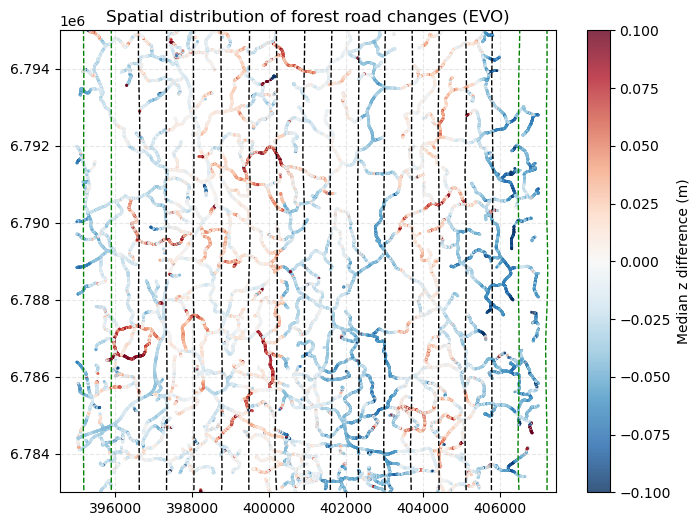

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

middle_points_x = [p[0] for p in middle_points]
middle_points_y = [p[1] for p in middle_points]

plt.figure(figsize=(8, 6))

sc = plt.scatter(
    middle_points_x,
    middle_points_y,
    c=buffer_of_median_z_diff,
    cmap='RdBu_r',
    s=1,
    alpha=0.8,
    vmin=-0.1, vmax=0.1
)

plt.colorbar(sc, label="Median z difference (m)")
plt.title("Spatial distribution of forest road changes (EVO)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')

# Read and plot shapefile
# flown_polyline_path = r"E:\ALS_DATA\NLS_20p_EVO_large_tiles\metadata\lentoradat_shape\Lento_3_20250608\Padasjoki_20pts_osalento_3_20250000_Flown_Polyline.shp"
# flown_polyline_path = r"E:\ALS_DATA\NLS_20p_EVO_large_tiles\metadata\lentoradat_shape\Lento_2_20250608\Padasjoki_20pts_osalento_2_20250000_Flown_Polyline.shp"
flown_polyline_path1 = r"E:\ALS_DATA\NLS_20p_EVO_large_tiles\metadata\lentoradat_shape\Lento_4_20250610\Padasjoki_20pts_osalento_4_20250000_Flown_Polyline.shp"
flown_polyline_path2 = r"E:\ALS_DATA\NLS_20p_EVO_large_tiles\metadata\lentoradat_shape\Lento_5_20250614\Padasjoki_20pts_osalento_5_20250000_Flown_Polyline.shp"
flown_polyline_path3 = r"E:\ALS_DATA\NLS_20p_EVO_large_tiles\metadata\lentoradat_shape\Lento_6_20250614\Padasjoki_20pts_osalento_6_20250000_Flown_Polyline.shp"
gdf = gpd.read_file(flown_polyline_path1)
gdf.plot(ax=plt.gca(), color='green', linewidth=1, linestyle='--')
gdf = gpd.read_file(flown_polyline_path2)
gdf.plot(ax=plt.gca(), color='green', linewidth=1, linestyle='--')
gdf = gpd.read_file(flown_polyline_path3)
gdf.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='--')

plt.xlim(395000.0, 407000.0)
plt.ylim(6783000.0, 6795000.0)

plt.show()


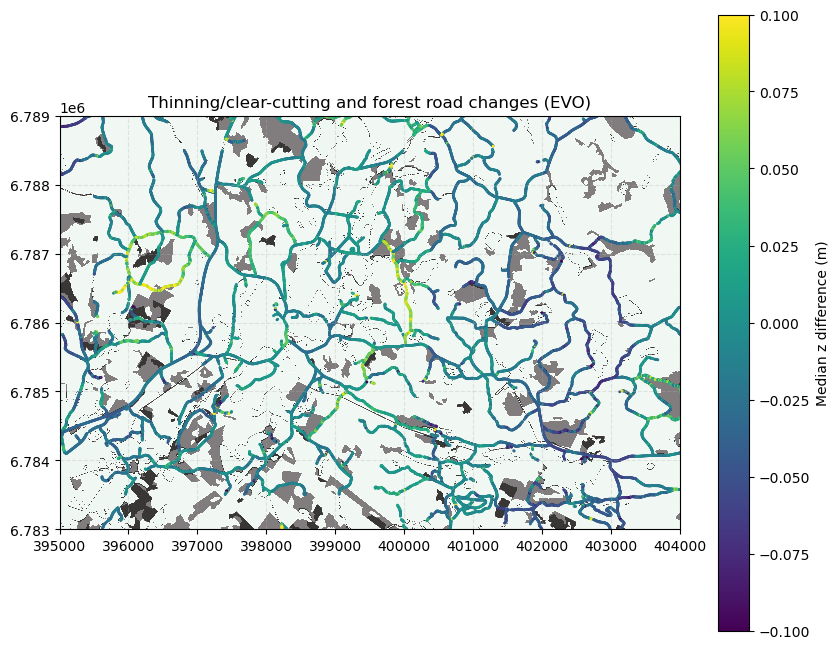

In [153]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.colors import ListedColormap, BoundaryNorm


tif = r"E:\muutostesti_leena_lokakuu2025\hakkuuluokittelu\dif3m_prop_thr_result_col_testi1.tif"

fig, ax = plt.subplots(figsize=(10, 8))

# Example colors for classes 0–4
# Replace these with the colors you want
colors = [
    "#eff7f2",  # class 0
    "#383736",  # class 1
    "#817d7f",  # class 2

    "#f8faf6",  # class 3
    "#f1f8f3"   # class 4
]

cmap = ListedColormap(colors)
norm = BoundaryNorm([0,1,2,3,4,5], cmap.N)

tif = r"E:\muutostesti_leena_lokakuu2025\hakkuuluokittelu\dif3m_prop_thr_result_col_testi1.tif"

with rasterio.open(tif) as src:
    show(src, ax=ax, cmap=cmap, norm=norm)

# green: avohakkuu, clear-cutting
# yellow: harvennus, thinning

middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]

sc = ax.scatter(
    middle_points_x,
    middle_points_y,
    c=buffer_of_median_z_diff,
    cmap="viridis",
    s=1,
    alpha=1.0,
    vmin=-0.1,
    vmax=0.1
)

cbar = fig.colorbar(sc, ax=ax, label="Median z difference (m)")

ax.set_title("Thinning/clear-cutting and forest road changes (EVO)")
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_aspect('equal')

ax.set_xlim([395000, 404000])
ax.set_ylim([6783000, 6789000])

# plt.xlim(395000.0, 407000.0)
# plt.ylim(6783000.0, 6795000.0)


plt.show()





#### Change detection: Surface variation

In [1]:
from scipy.spatial import cKDTree, KDTree

def radius_ball_search(points, radius):
    tree = cKDTree(points)
    neighbors_indices = tree.query_ball_point(points, r=radius)
    return neighbors_indices


def compute_surface_variation(points, neighbors_indices):
    surface_variations = np.zeros(len(points))

    for i, idxs in enumerate(neighbors_indices):
        if len(idxs) < 3:
            surface_variations[i] = np.nan  # not enough points for PCA
            continue

        neighbors = points[idxs]
        centroid = np.mean(neighbors, axis=0)
        centered = neighbors - centroid

        cov = np.cov(centered.T)

        eigvals = np.linalg.eigvalsh(cov)
        eigvals = np.sort(eigvals)

        lam_sum = np.sum(eigvals)
        if lam_sum > 0:
            surface_variations[i] = eigvals[0] / lam_sum
        else:
            surface_variations[i] = 0.0

    return surface_variations


In [54]:
import os
import laspy
import numpy as np

folder_path_5p = r"E:\ALS_DATA\NLS_5p_PADASJOKI_road_patches\laz_files_split_along_road_vectors_with_dl_predictions"
folder_path_20p = r"E:\ALS_DATA\NLS_20p_EVO_road_patches_with_preds"

buffer_of_median_sv_difference = []
buffer_of_mean_sv_difference = []
buffer_of_sv_difference = []
middle_points = []

files_with_no_correspondence = {}

for i, file in enumerate(os.listdir(folder_path_20p)):
    if i % 10 == 0:
        print(i)
    data_5p_laz = os.path.splitext(file)[0] + ".laz"

    data_5p = os.path.join(folder_path_5p, data_5p_laz)
    data_20p = os.path.join(folder_path_20p, file)

    points_5p = laspy.read(data_5p)
    points_20p = laspy.read(data_20p)

    xyz_5p = np.vstack((points_5p.x, points_5p.y, points_5p.z)).T
    xyz_20p = np.vstack((points_20p.x, points_20p.y, points_20p.z)).T

    predictions_20p = points_20p.prediction
    predictions_5p = points_5p.prediction

    mask_5p = predictions_5p != 1
    xyz_5p_road = xyz_5p[mask_5p]

    mask_20p = predictions_20p != 1
    xyz_20p_road = xyz_20p[mask_20p]

    splitcode_road_5p = points_5p[mask_5p].splitcode

    if mask_5p.sum() > 50:
        tree = KDTree(xyz_20p_road)
        dist, idx = tree.query(xyz_5p_road, k=1)

        # print(idx[:100])
        # print(len(idx))

        neighbor_indices_5p = radius_ball_search(xyz_5p_road, 1.0)
        neighbor_indices_20p = radius_ball_search(xyz_20p_road, 1.0)

        surface_variations_5p = compute_surface_variation(xyz_5p_road, neighbor_indices_5p)
        surface_variations_20p = compute_surface_variation(xyz_20p_road, neighbor_indices_20p)

        # print(len(surface_variations_5p))
        # print(len(surface_variations_20p))

        surface_variations_20p = surface_variations_20p[idx.flatten()]

        # print(len(surface_variations_20p))

        for i in np.unique(splitcode_road_5p):
            splitcode_mask = splitcode_road_5p == i

            xyz_20p_road_reordered = xyz_20p_road[idx.flatten()]

            surface_variation_difference = surface_variations_20p[splitcode_mask] - surface_variations_5p[splitcode_mask]

            splitcode_dist = [dist for dist, m in zip(dist, splitcode_mask) if m]

            if np.median(splitcode_dist) < 1.0: # sanity check that both data cover the road
                buffer_of_sv_difference.append(surface_variation_difference)
                buffer_of_median_sv_difference.append(np.nanmedian(surface_variation_difference))
                buffer_of_mean_sv_difference.append(np.nanmean(surface_variation_difference))

                center_xy = xyz_5p_road[splitcode_mask, :2].mean(axis=0) 
                middle_points.append(center_xy)

            else:
                if file not in files_with_no_correspondence:
                    files_with_no_correspondence[file] = []
                files_with_no_correspondence[file].append(i)



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130


Nan values 20 / 75602
nan


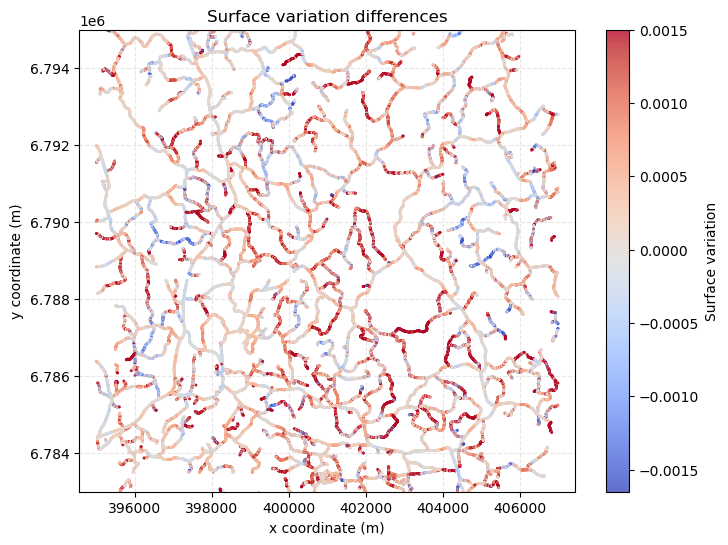

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy array if needed
buffer_of_median_sv_difference = np.array(buffer_of_median_sv_difference)

nan_count = np.isnan(buffer_of_median_sv_difference).sum()

print(f"Nan values {nan_count} / {len(buffer_of_median_sv_difference)}")

print(np.median(buffer_of_median_sv_difference))

middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]


plt.figure(figsize=(8, 6))
sc = plt.scatter(
    middle_points_x,          # X
    middle_points_y,          # Y
    c=buffer_of_median_sv_difference,
    cmap='coolwarm',                 # Blue for positive, red for negative
    s=1,                    # marker size
    alpha=0.8,
    vmin=0.0015, vmax=-0.0015
)

plt.colorbar(sc, label="Surface variation")
plt.title("Surface variation differences")
plt.xlabel("x coordinate (m)")
plt.ylabel("y coordinate (m)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')  # keep aspect ratio true to scale

plt.xlim(395000.0, 407000.0)
plt.ylim(6783000.0, 6795000.0)

plt.show()

Nan values 20 / 75602
0.00019192529595851403
75602
75602
18446
18446
18446
Significant surface variation changes: 18446 / 75602
Proportion of significant changes: 0.244


(6783000.0, 6795000.0)

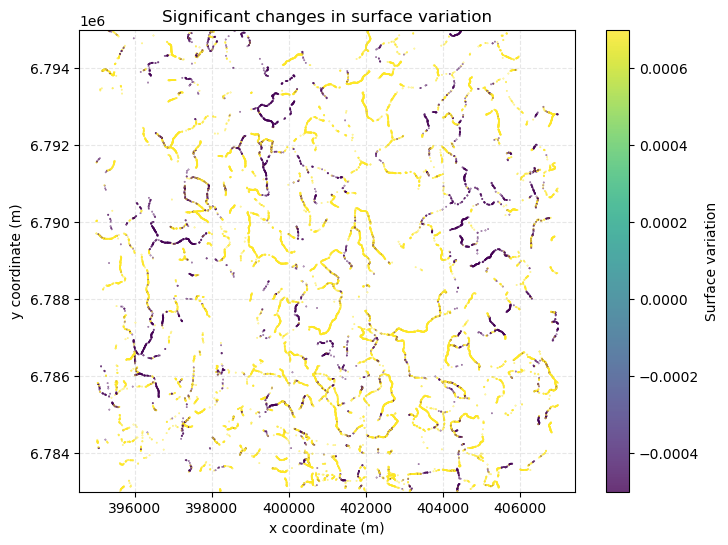

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

buffer_of_median_sv_difference = np.array(buffer_of_median_sv_difference)

nan_count = np.isnan(buffer_of_median_sv_difference).sum()
print(f"Nan values {nan_count} / {len(buffer_of_median_sv_difference)}")
print(np.nanmedian(buffer_of_median_sv_difference))

middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]

print(len(buffer_of_median_sv_difference))
print(len(middle_points_x))
# mask values between -0.001 and 0.001
mask = (buffer_of_median_sv_difference < -0.00051) | (buffer_of_median_sv_difference > 0.00083) #83
mask = (buffer_of_median_sv_difference < -0.00051) | (buffer_of_median_sv_difference > 0.00083) #83
# mask = (buffer_of_median_sv_difference < -0.0007) | (buffer_of_median_sv_difference > 0.0009)
vals = buffer_of_median_sv_difference[mask]
masked_middle_points_x = [p for p, m in zip(middle_points_x, mask) if m]
masked_middle_points_y = [p for p, m in zip(middle_points_y, mask) if m]
print(len(vals))
print(len(masked_middle_points_x))
print(len(masked_middle_points_y))

print(f"Significant surface variation changes: {len(vals)} / {len(buffer_of_median_sv_difference)}")
print(f"Proportion of significant changes: {len(vals) / len(buffer_of_median_sv_difference):.3f}")

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    masked_middle_points_x,
    masked_middle_points_y,
    c=vals,
    cmap='viridis',
    s=0.1,
    alpha=0.8,
    vmin=-0.0005,
    vmax=0.0007
)

plt.colorbar(sc, label="Surface variation")
plt.title("Significant changes in surface variation")
plt.xlabel("x coordinate (m)")
plt.ylabel("y coordinate (m)")
plt.grid(linestyle='--', alpha=0.3)
plt.axis('equal')

plt.xlim(395000.0, 407000.0)
plt.ylim(6783000.0, 6795000.0)

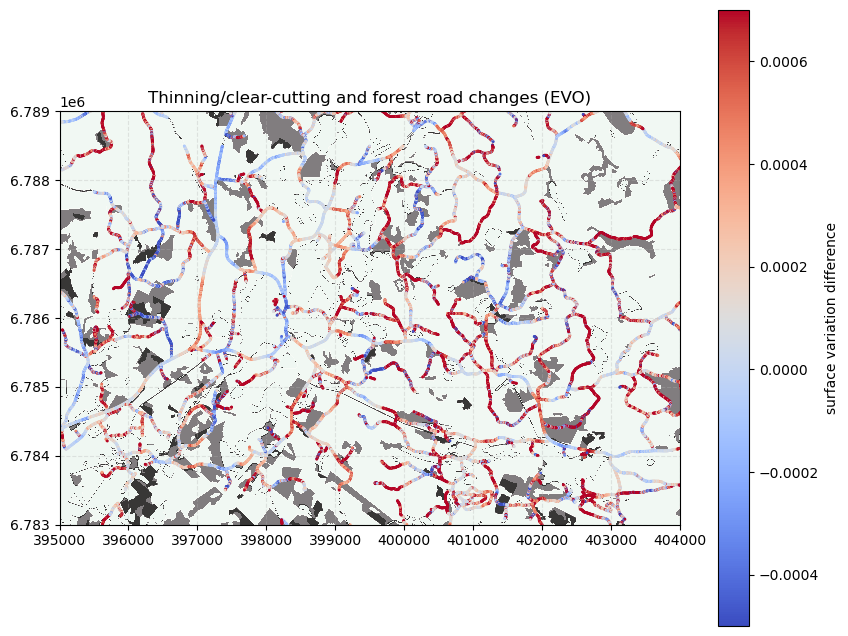

In [33]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.colors import ListedColormap, BoundaryNorm


tif = r"E:\muutostesti_leena_lokakuu2025\hakkuuluokittelu\dif3m_prop_thr_result_col_testi1.tif"

fig, ax = plt.subplots(figsize=(10, 8))

# Example colors for classes 0–4
# Replace these with the colors you want
colors = [
    "#eff7f2",  # class 0
    "#383736",  # class 1
    "#817d7f",  # class 2

    "#f8faf6",  # class 3
    "#f1f8f3"   # class 4
]

cmap = ListedColormap(colors)
norm = BoundaryNorm([0,1,2,3,4,5], cmap.N)

tif = r"E:\muutostesti_leena_lokakuu2025\hakkuuluokittelu\dif3m_prop_thr_result_col_testi1.tif"

with rasterio.open(tif) as src:
    show(src, ax=ax, cmap=cmap, norm=norm)

# green: avohakkuu, clear-cutting
# yellow: harvennus, thinning

middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]

sc = ax.scatter(
    middle_points_x,
    middle_points_y,
    c=buffer_of_median_sv_difference,
    cmap="coolwarm",
    s=1,
    alpha=1.0,
    vmin=-0.0005,
    vmax=0.0007
)

cbar = fig.colorbar(sc, ax=ax, label="surface variation difference")

ax.set_title("Thinning/clear-cutting and forest road changes (EVO)")
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_aspect('equal')

ax.set_xlim([395000, 404000])
ax.set_ylim([6783000, 6789000])

# plt.xlim(395000.0, 407000.0)
# plt.ylim(6783000.0, 6795000.0)


plt.show()





In [ ]:
import numpy as np
import py4dgeo
import py4dgeo.util
import laspy

# --- Load data ---
def load_las(filename):
    las = laspy.read(filename)
    return np.vstack((las.x, las.y, las.z)).T

cloud = load_las(r"E:\ALS_DATA\NLS_5p_PADASJOKI_road_patches\laz_files_split_along_road_vectors_with_dl_predictions\461795483_19150.laz")   # used for M3C2 core points
cloud2 = load_las(r"E:\ALS_DATA\NLS_20p_EVO_road_patches\461795483_19150.las")        # "After"

epoch1, epoch2 = py4dgeo.read_from_las(
    r"C:\Users\telukkari\Documents\Data\5p_example.las", r"C:\Users\telukkari\Documents\Data\20p_example.las"
)


corepoints = epoch1.cloud

m3c2 = py4dgeo.M3C2(
    epochs=(epoch1, epoch2),
    corepoints=corepoints,
    cyl_radius=1.0,
    normal_radii=[1.0,1.5],
    registration_error=(0.006)
)


distances, uncertainties = m3c2.run()

print(f"Median M3C2 distances: {np.nanmedian(distances):.3f} m")
print(f"Std. dev. of M3C2 distances: {np.nanstd(distances):.3f} m")

print(uncertainties)
print(uncertainties["lodetection"][:100])
print(np.max(uncertainties["lodetection"]))
print(uncertainties["num_samples1"][:100])
print(uncertainties["num_samples2"][:100])

print("M3C2 distances:", distances[:10])
# print("M3C2 mean distance:", np.mean(distances))
# print("M3C2 median distance:", np.median(distances))
# print(cloud1.shape, cloud2.shape)
# print("Length of M3C2 distances:", len(distances))
# directions = m3c2.directions()
# print(directions[:100])


c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


[2025-11-10 09:39:36][INFO] Reading point cloud from file 'C:\Users\telukkari\Documents\Data\5p_example.las'
[2025-11-10 09:39:36][INFO] Reading point cloud from file 'C:\Users\telukkari\Documents\Data\20p_example.las'
[2025-11-10 09:39:36][INFO] Building KDTree structure with leaf parameter 10
[2025-11-10 09:39:36][INFO] Building KDTree structure with leaf parameter 10
Median M3C2 distances: 0.010 m
Std. dev. of M3C2 distances: 0.016 m
[(0.02235312, 0.01376824, 20, 0.02350528, 28)
 (0.02929813, 0.0137701 , 17, 0.037125  , 20)
 (0.02637346, 0.01413118, 15, 0.03185352, 24) ...
 (0.0248284 , 0.02937114, 22, 0.0222027 , 94)
 (0.0295819 , 0.03089414, 19, 0.05373646, 89)
 (0.03301028, 0.03102331, 16, 0.06776171, 80)]
[0.02235312 0.02929813 0.02637346 0.02027594 0.02281877 0.02278762
 0.01999171 0.01944792 0.01985948 0.02082084 0.0205871  0.0204678
 0.0202075  0.01897295 0.01846386 0.0200718  0.02049155 0.02052526
 0.01989653 0.01934253 0.01964274 0.01993162 0.01964534 0.01946094
 0.01886456

#### Change detection: M3C2 distances

In [42]:
import laspy 
import numpy as np
import os
from sklearn.neighbors import KDTree
import py4dgeo


folder_path_5p = r"E:\ALS_DATA\NLS_5p_PADASJOKI_road_patches\laz_files_split_along_road_vectors_with_dl_predictions"
folder_path_20p = r"E:\ALS_DATA\NLS_20p_EVO_road_patches_with_preds"

buffer_of_mean_distances = []
buffer_of_median_distances = []
buffer_of_distances = []
middle_points = []
proportions_of_significant_changes = []

number_of_significant_changes = 0
all_points = 0
number_of_5m_segments = 0

for file in os.listdir(folder_path_20p):
    data_5p_laz = os.path.splitext(file)[0] + ".laz"

    data_5p = os.path.join(folder_path_5p, data_5p_laz)
    data_20p = os.path.join(folder_path_20p, file)

    points_5p = laspy.read(data_5p)
    points_20p = laspy.read(data_20p)

    xyz_5p = np.vstack((points_5p.x, points_5p.y, points_5p.z)).T
    xyz_20p = np.vstack((points_20p.x, points_20p.y, points_20p.z)).T

    predictions_5p = points_5p.prediction

    mask = predictions_5p != 1
    xyz_5p_road = xyz_5p[mask]

    splitcode_5p = points_5p[mask].splitcode

    predictions_20p = points_20p.prediction

    mask_20p = predictions_20p != 1
    xyz_20p_road = xyz_20p[mask_20p]

    epoch1 = py4dgeo.Epoch(xyz_5p_road)
    epoch2 = py4dgeo.Epoch(xyz_20p_road)

    corepoints = epoch1.cloud

    m3c2 = py4dgeo.M3C2(
        epochs=(epoch1, epoch2),
        corepoints=corepoints,
        cyl_radius=1.0,
        normal_radii=[0.5,1.0,1.5],
        max_distance=(1.0),
        registration_error=(0.02) # TODO
    )

    distances, uncertainties = m3c2.run()

    # print(f"Median M3C2 distances: {np.nanmedian(distances):.3f} m")
    # print(f"Std. dev. of M3C2 distances: {np.nanstd(distances):.3f} m")

    change_sign = np.where(abs(distances) > uncertainties["lodetection"], True, False)

    # print(f"Number of significant changes: {np.sum(change_sign)} / {len(change_sign)}")
    number_of_significant_changes += np.sum(change_sign)
    all_points += len(change_sign)


    for i in np.unique(splitcode_5p):
        # z_diff = xyz_20p[idx.flatten(), 2] - xyz_5p_road[:, 2]

        if file in files_with_no_correspondence: # for checking that both 5p and 20p data cover the same segment
            if i in files_with_no_correspondence[file]:
                continue
        else:

            splitcode_mask = splitcode_5p == i
            distances_masked = distances[splitcode_mask]

            buffer_of_distances.append(distances_masked)
            buffer_of_median_distances.append(np.median(distances_masked))
            buffer_of_mean_distances.append(np.mean(distances_masked))

            change_sign_masked = change_sign[splitcode_mask]
            proportion_of_significant_changes = np.sum(change_sign_masked) / len(change_sign_masked)
            proportions_of_significant_changes.append(proportion_of_significant_changes)

            center_xy = xyz_5p_road[splitcode_mask, :2].mean(axis=0)
            middle_points.append(center_xy)

            number_of_5m_segments += 1


[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:27][INFO] Building KDTree structure with leaf parameter 10
[2025-11-21 10:23:28][INFO] Building KDTree structure with leaf parameter 10

In [43]:
print(f"Total number of segments: {number_of_5m_segments}, which corresponds to {number_of_5m_segments * 5 / 1000} km of road.")
print(f"Total number of significant changes: {number_of_significant_changes} / {all_points}")
print(f"Total number of significant changes: {number_of_significant_changes / all_points}")

Total number of segments: 70901, which corresponds to 354.505 km of road.
Total number of significant changes: 1293527 / 9705669
Total number of significant changes: 0.13327540842367486


Nan values 1197 / 70901
nan


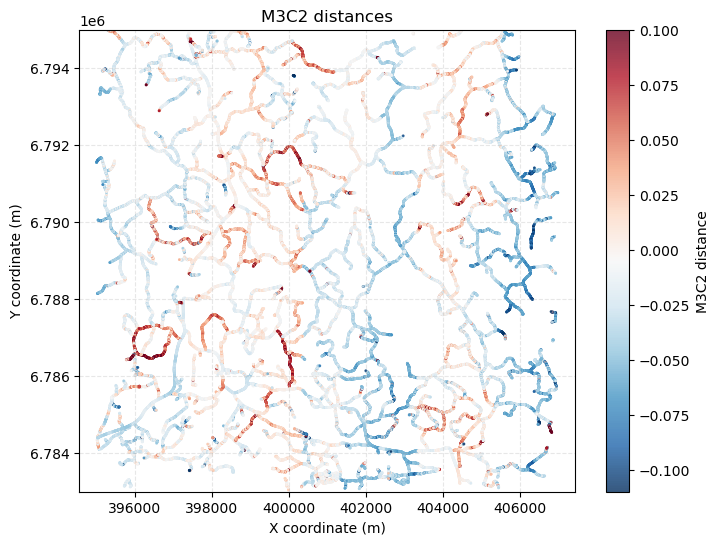

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy array if needed
buffer_of_median_distances = np.array(buffer_of_median_distances)

nan_count = np.isnan(buffer_of_median_distances).sum()

print(f"Nan values {nan_count} / {len(buffer_of_median_distances)}")

print(np.median(buffer_of_median_distances))

middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]


plt.figure(figsize=(8, 6))
sc = plt.scatter(
    middle_points_x,          # X
    middle_points_y,          # Y
    c=buffer_of_median_distances,
    cmap='RdBu_r',                 # Blue for positive, red for negative
    s=1,                    # marker size
    alpha=0.8,
    vmin=0.1, vmax=-0.1
)

plt.colorbar(sc, label="M3C2 distance")
plt.title("M3C2 distances")
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')  # keep aspect ratio true to scale

plt.xlim(395000.0, 407000.0)
plt.ylim(6783000.0, 6795000.0)

plt.show()

Nan values 0 / 70901
0.0


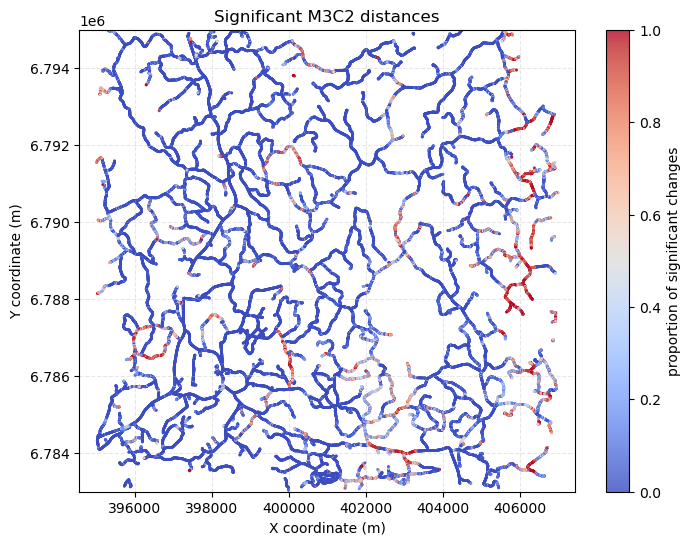

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy array if needed
proportions_of_significant_changes = np.array(proportions_of_significant_changes)

nan_count = np.isnan(proportions_of_significant_changes).sum()

print(f"Nan values {nan_count} / {len(proportions_of_significant_changes)}")

print(np.median(proportions_of_significant_changes))

middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]


plt.figure(figsize=(8, 6))
sc = plt.scatter(
    middle_points_x,          # X
    middle_points_y,          # Y
    c=proportions_of_significant_changes,
    cmap='coolwarm',                 # Blue for positive, red for negative
    s=1,                    # marker size
    alpha=0.8,
    vmin=0.00, vmax=1.0
)

plt.colorbar(sc, label="proportion of significant changes")
plt.title("Significant M3C2 distances")
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')  # keep aspect ratio true to scale

plt.xlim(395000.0, 407000.0)
plt.ylim(6783000.0, 6795000.0)

plt.show()